In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
import csv
import os


### Implementare gradient descrescator stocastic si bazat pe batch-uri

In [ ]:
class MySGDRegression:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.coef_ = None
        self.intercept_ = None
    
    def fit(self, X, y):

        X = np.array(X)
        y = np.array(y)

        if X.ndim == 1:
            X = X.reshape(-1, 1)
        X_with_bias = np.c_[np.ones((X.shape[0],)), X]

        # Initializam weights aleatorii mici
        self.weights = np.random.randn(X_with_bias.shape[1]) * 0.01

        # Antrenare cu Batch Gradient Descent (BGD)
        for _ in range(self.epochs):
            # predictii pentru toate datele
            y_pred = X_with_bias.dot(self.weights)

            # calcul eroare
            error = y_pred - y

            # calcul gradient
            gradient = (1 / len(y)) * X_with_bias.T.dot(error)

            # actualizare weights
            self.weights -= self.learning_rate * gradient

        # setam intercept_ si coef_ pentru compatibilitate cu sklearn
        self.intercept_ = self.weights[0]
        self.coef_ = self.weights[1:]

        return self

    
    def predict(self, X):
        X = np.array(X)

        # daca e unidimensional, il convertim in forma (n, 1)
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        X_with_bias = np.c_[np.ones((X.shape[0],)), X]

        # calculam predictiile
        return X_with_bias.dot(np.append(self.intercept_, self.coef_))


class MyBGDRegression:
    def __init__(self, learning_rate=0.01, epochs=1000, batch_size=32):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.coef_ = None
        self.intercept_ = None
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        if X.ndim == 1:
            X = X.reshape(-1, 1)
        X_with_bias = np.c_[np.ones((X.shape[0],)), X]

        # initializam wheigths cu valori aleatorii mici
        num_features = X_with_bias.shape[1]
        self.weights = np.random.randn(num_features) * 0.01

        n_samples = X_with_bias.shape[0]

        # antrenare pe epoci
        for _ in range(self.epochs):
            # amestecam datele pentru fiecare epoca
            indices = np.random.permutation(n_samples)
            X_shuffled = X_with_bias[indices]
            y_shuffled = y[indices]

            # procesam fiecare batch
            for start_idx in range(0, n_samples, self.batch_size):
                end_idx = min(start_idx + self.batch_size, n_samples)

                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # calculam predictiile pentru batch
                y_pred = X_batch.dot(self.weights)

                # calculam erorile
                errors = y_pred - y_batch

                # calculam gradientul si actualizam weights
                gradient = (1 / len(X_batch)) * X_batch.T.dot(errors)
                self.weights -= self.learning_rate * gradient

        # Setam intercept_ si coef_ pentru compatibilitate cu sklearn
        self.intercept_ = self.weights[0]
        self.coef_ = self.weights[1:]

        return self
    
    def predict(self, X):
        # Convertim in array
        X = np.array(X)

        # Daca e unidimensional, il convertim in forma (n, 1)
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        # Adaugam coloana de 1 pentru bias (intercept)
        X_with_bias = np.c_[np.ones((X.shape[0],)), X]

        # Calculam predictiile
        return X_with_bias.dot(np.append(self.intercept_, self.coef_))


### Functii pentru plotarea datelor fie cand avem un feature, fie cand avem doua

In [ ]:
def plotDataHistogram(x, variableName):
    plt.hist(x, 10)
    plt.title('Histogram of ' + variableName)
    plt.xlabel(variableName)
    plt.ylabel('Frequency')
    plt.show()


def plot2DData(x, y, xLabel, yLabel, title=None):
    plt.scatter(x, y, c='r', marker='o')
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    if title:
        plt.title(title)
    plt.show()


def plot3DData(x1Train, x2Train, yTrain, x1Model=None, x2Model=None, yModel=None, 
              x1Test=None, x2Test=None, yTest=None, title=None):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    if x1Train:
        ax.scatter(x1Train, x2Train, yTrain, c='r', marker='o', label='train data')
    if x1Model:
        ax.scatter(x1Model, x2Model, yModel, c='b', marker='_', label='learnt model')
    if x1Test:
        ax.scatter(x1Test, x2Test, yTest, c='g', marker='^', label='test data')
    
    if title:
        plt.title(title)
    ax.set_xlabel("GDP per Capita")
    ax.set_ylabel("Freedom")
    ax.set_zlabel("Happiness")
    plt.legend()
    plt.show()


def plotData(x1, y1, x2=None, y2=None, x3=None, y3=None, title=None):
    plt.figure(figsize=(10, 6))
    if x1 is not None and y1 is not None:
        plt.plot(x1, y1, 'ro', label='train data')
    if x2 is not None:
        plt.plot(x2, y2, 'b-', label='learnt model')
    if x3 is not None:
        plt.plot(x3, y3, 'g^', label='test data')
    plt.title(title)
    plt.xlabel('GDP per Capita')
    plt.ylabel('Happiness Score')
    plt.legend()
    plt.show()

### Functii pentru incarcarea datelor dintr-o coloana, dar si din mai multe

In [74]:
def loadData(fileName, inputVarName, outputVarName):
    data = []
    dataNames = []
    with open(fileName) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                dataNames = row
            else:
                data.append(row)
            line_count += 1
    
    selectedVar = dataNames.index(inputVarName)
    inputs = [float(data[i][selectedVar]) for i in range(len(data))]
    
    selectedOutput = dataNames.index(outputVarName)
    outputs = [float(data[i][selectedOutput]) for i in range(len(data))]
    
    return inputs, outputs


def loadDataMoreInputs(fileName, inputVarNames, outputVarName):
    data = []
    dataNames = []
    with open(fileName) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                dataNames = row
            else:
                data.append(row)
            line_count += 1
    
    selectedVars = [dataNames.index(inputVarName) for inputVarName in inputVarNames]
    inputs = [[float(data[i][selectedVar]) for selectedVar in selectedVars] for i in range(len(data))]
    
    selectedOutput = dataNames.index(outputVarName)
    outputs = [float(data[i][selectedOutput]) for i in range(len(data))]
    
    return inputs, outputs

### Normalizarea datelor

In [80]:
def normalisation(trainData, testData):
    scaler = StandardScaler()
    if not isinstance(trainData[0], list):
        # Codificăm fiecare exemplu într-o listă
        trainData = [[d] for d in trainData]
        testData = [[d] for d in testData]
        
        scaler.fit(trainData)  # Antrenăm pe datele de antrenament
        normalisedTrainData = scaler.transform(trainData)  # Aplicăm transformarea pe datele de antrenament
        normalisedTestData = scaler.transform(testData)    # Aplicăm aceeași transformare pe datele de test
        
        # Decodificăm listele în valori simple
        normalisedTrainData = [el[0] for el in normalisedTrainData]
        normalisedTestData = [el[0] for el in normalisedTestData]
    else:
        scaler.fit(trainData)  # Antrenăm pe datele de antrenament
        normalisedTrainData = scaler.transform(trainData)  # Aplicăm transformarea pe datele de antrenament
        normalisedTestData = scaler.transform(testData)    # Aplicăm aceeași transformare pe datele de test
    
    return normalisedTrainData, normalisedTestData

### Descrierea regresiei univariata, respectiv bivariata

In [91]:
def univariateRegression():
    print("\n=== REGRESIA UNIVARIATA: Happiness = f(GDP) ===\n")
    
    # Încărcăm datele
    filePath = os.path.join('data', 'world-happiness-report-2017.csv')
    try:
        inputs, outputs = loadData(filePath, 'Economy..GDP.per.Capita.', 'Happiness.Score')
    except FileNotFoundError:
        print(f"Eroare: Fisierul {filePath} nu a fost gasit. Verificati calea.")
        print("Setam calea catre directorul curent pentru teste...")
        inputs, outputs = loadData('world-happiness-report-2017.csv', 'Economy..GDP.per.Capita.', 'Happiness.Score')
    
    # Vizualizăm distribuția datelor
    plotDataHistogram(inputs, 'GDP per Capita')
    plotDataHistogram(outputs, 'Happiness Score')
    
    # Verificăm linearitatea (relația între GDP și fericire)
    plot2DData(inputs, outputs, 'GDP per Capita', 'Happiness Score', 'GDP vs. Happiness')
    
    # Împărțim datele în seturi de antrenament (80%) și testare (20%)
    np.random.seed(5)
    indexes = [i for i in range(len(inputs))]
    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace=False)
    testSample = [i for i in indexes if i not in trainSample]
    
    trainInputs = [inputs[i] for i in trainSample]
    trainOutputs = [outputs[i] for i in trainSample]
    testInputs = [inputs[i] for i in testSample]
    testOutputs = [outputs[i] for i in testSample]
    
    # Vizualizăm datele de antrenament și testare
    plotData(trainInputs, trainOutputs, None, None, testInputs, testOutputs, "Date de antrenament și testare")
    
    # Normalizăm datele
    trainInputs, testInputs = normalisation(trainInputs, testInputs)
    trainOutputs, testOutputs = normalisation(trainOutputs, testOutputs)
    
    # 1. Antrenare folosind SGD propriu
    print("\n--- Antrenare cu SGD propriu ---")
    regressor_sgd = MySGDRegression(learning_rate=0.01, epochs=1000)
    regressor_sgd.fit(trainInputs, trainOutputs)
    w0_sgd, w1_sgd = regressor_sgd.intercept_, regressor_sgd.coef_[0]
    print(f"Modelul învățat (SGD): f(x) = {w0_sgd:.6f} + {w1_sgd:.6f} * x")
    
    # 2. Antrenare folosind BGD propriu
    print("\n--- Antrenare cu BGD propriu ---")
    regressor_bgd = MyBGDRegression(learning_rate=0.01, epochs=1000, batch_size=32)
    regressor_bgd.fit(trainInputs, trainOutputs)
    w0_bgd, w1_bgd = regressor_bgd.intercept_, regressor_bgd.coef_[0]
    print(f"Modelul învățat (BGD): f(x) = {w0_bgd:.6f} + {w1_bgd:.6f} * x")
    
    # vizualizam modelul învățat (SGD)
    noOfPoints = 1000
    xref = np.linspace(min(trainInputs), max(trainInputs), noOfPoints)
    yref_sgd = [w0_sgd + w1_sgd * el for el in xref]
    plotData(trainInputs, trainOutputs, xref, yref_sgd, None, None, "Date de antrenament și model SGD")
    
    # modelul învățat (BGD)
    yref_bgd = [w0_bgd + w1_bgd * el for el in xref]
    plotData(trainInputs, trainOutputs, xref, yref_bgd, None, None, "Date de antrenament și model BGD")
    
    # Facem predictii pentru datele de test
    # SGD
    computedTestOutputs_sgd = regressor_sgd.predict(testInputs)
    plotData(None, None, testInputs, computedTestOutputs_sgd, testInputs, testOutputs, "Predicții vs. date reale (SGD)")
    
    # BGD
    computedTestOutputs_bgd = regressor_bgd.predict(testInputs)
    plotData(None, None, testInputs, computedTestOutputs_bgd, testInputs, testOutputs, "Predicții vs. date reale (BGD)")
    
    # eroarea de predicție pentru SGD
    error_sgd = mean_squared_error(testOutputs, computedTestOutputs_sgd)
    print(f"\nEroare de predicție (SGD): {error_sgd:.6f}")
    
    # eroarea de predicție pentru BGD
    error_bgd = mean_squared_error(testOutputs, computedTestOutputs_bgd)
    print(f"Eroare de predicție (BGD): {error_bgd:.6f}")
    
     # 3. Antrenare folosind SGDRegressor (BGD cu tool)
    print("\n--- Antrenare cu SGDRegressor (tool sklearn) ---")
    from sklearn.linear_model import SGDRegressor

    regressor_tool = SGDRegressor(
        max_iter=1000,
        learning_rate='constant',
        eta0=0.01,
        penalty=None,
        random_state=42
    )
    trainInputs_reshaped = np.array(trainInputs).reshape(-1, 1)
    testInputs_reshaped = np.array(testInputs).reshape(-1, 1)

    regressor_tool.fit(trainInputs_reshaped, trainOutputs)

    w0_tool = regressor_tool.intercept_[0]
    w1_tool = regressor_tool.coef_[0]
    print(f"Modelul învățat (SGDRegressor): f(x) = {w0_tool:.6f} + {w1_tool:.6f} * x")

    # Vizualizare model
    yref_tool = [w0_tool + w1_tool * el for el in xref]
    plotData(trainInputs, trainOutputs, xref, yref_tool, None, None, "Date de antrenament și model SGDRegressor")

    # Predicții și eroare
    computedTestOutputs_tool = regressor_tool.predict(testInputs_reshaped)
    plotData(None, None, testInputs, computedTestOutputs_tool, testInputs, testOutputs, "Predicții vs. date reale (SGDRegressor)")
    error_tool = mean_squared_error(testOutputs, computedTestOutputs_tool)
    print(f"Eroare de predicție (SGDRegressor): {error_tool:.6f}")
    
    return


def bivariateRegression():
    print("\n=== REGRESIA BIVARIATĂ: Happiness = f(GDP, Freedom) ===\n")
    
    # Încărcăm datele
    filePath = os.path.join('data', 'world-happiness-report-2017.csv')
    try:
        inputs, outputs = loadDataMoreInputs(filePath, ['Economy..GDP.per.Capita.', 'Freedom'], 'Happiness.Score')
    except FileNotFoundError:
        print(f"Eroare: Fișierul {filePath} nu a fost găsit. Verificați calea.")
        print("Setăm calea către directorul curent pentru teste...")
        inputs, outputs = loadDataMoreInputs('world-happiness-report-2017.csv', ['Economy..GDP.per.Capita.', 'Freedom'], 'Happiness.Score')
    
    # Extragem featuriile
    feature1 = [ex[0] for ex in inputs]  # GDP
    feature2 = [ex[1] for ex in inputs]  # Freedom
    
    # Vizualizăm distribuția datelor
    plotDataHistogram(feature1, 'GDP per Capita')
    plotDataHistogram(feature2, 'Freedom')
    plotDataHistogram(outputs, 'Happiness Score')
    
    # Verificăm linearitatea relației 3D
    plot3DData(feature1, feature2, outputs, None, None, None, None, None, None, 'GDP vs Freedom vs Happiness')
    
    # Împărțim datele în seturi de antrenament (80%) și testare (20%)
    np.random.seed(5)
    indexes = [i for i in range(len(inputs))]
    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace=False)
    testSample = [i for i in indexes if i not in trainSample]
    
    trainInputs = [inputs[i] for i in trainSample]
    trainOutputs = [outputs[i] for i in trainSample]
    testInputs = [inputs[i] for i in testSample]
    testOutputs = [outputs[i] for i in testSample]
    
    # Normalizăm datele
    trainInputs, testInputs = normalisation(trainInputs, testInputs)
    trainOutputs, testOutputs = normalisation(trainOutputs, testOutputs)
    
    # Extragem featuriile normalizate
    feature1train = [ex[0] for ex in trainInputs]
    feature2train = [ex[1] for ex in trainInputs]
    feature1test = [ex[0] for ex in testInputs]
    feature2test = [ex[1] for ex in testInputs]
    
    # Vizualizăm datele de antrenament și testare (normalizate)
    plot3DData(feature1train, feature2train, trainOutputs, None, None, None, 
              feature1test, feature2test, testOutputs, "Date de antrenament și testare (normalizate)")
    
    # 1. Antrenare folosind SGD propriu
    print("\n--- Antrenare cu SGD propriu ---")
    regressor_sgd = MySGDRegression(learning_rate=0.01, epochs=1000)
    regressor_sgd.fit(trainInputs, trainOutputs)
    w0_sgd, w1_sgd, w2_sgd = regressor_sgd.intercept_, regressor_sgd.coef_[0], regressor_sgd.coef_[1]
    print(f"Modelul învățat (SGD): f(x) = {w0_sgd:.6f} + {w1_sgd:.6f} * x1 + {w2_sgd:.6f} * x2")
    
    # 2. Antrenare folosind BGD propriu
    print("\n--- Antrenare cu BGD propriu ---")
    regressor_bgd = MyBGDRegression(learning_rate=0.01, epochs=1000, batch_size=32)
    regressor_bgd.fit(trainInputs, trainOutputs)
    w0_bgd, w1_bgd, w2_bgd = regressor_bgd.intercept_, regressor_bgd.coef_[0], regressor_bgd.coef_[1]
    print(f"Modelul învățat (BGD): f(x) = {w0_bgd:.6f} + {w1_bgd:.6f} * x1 + {w2_bgd:.6f} * x2")
    
    # Creăm reprezentarea numerică a modelului de regresie (pentru vizualizare)
    noOfPoints = 50
    xref1 = []
    val = min(feature1train)
    step1 = (max(feature1train) - min(feature1train)) / noOfPoints
    for _ in range(1, noOfPoints):
        for _ in range(1, noOfPoints):
            xref1.append(val)
        val += step1

    xref2 = []
    val = min(feature2train)
    step2 = (max(feature2train) - min(feature2train)) / noOfPoints
    for _ in range(1, noOfPoints):
        aux = val
        for _ in range(1, noOfPoints):
            xref2.append(aux)
            aux += step2
            
    # Calculăm valorile prezise pentru SGD
    yref_sgd = [w0_sgd + w1_sgd * el1 + w2_sgd * el2 for el1, el2 in zip(xref1, xref2)]
    
    # Calculăm valorile prezise pentru BGD
    yref_bgd = [w0_bgd + w1_bgd * el1 + w2_bgd * el2 for el1, el2 in zip(xref1, xref2)]
    
    # Vizualizăm modelul învățat (SGD)
    plot3DData(feature1train, feature2train, trainOutputs, xref1, xref2, yref_sgd, None, None, None, 
              'Date de antrenament și model SGD')
    
    # Vizualizăm modelul învățat (BGD)
    plot3DData(feature1train, feature2train, trainOutputs, xref1, xref2, yref_bgd, None, None, None, 
              'Date de antrenament și model BGD')
    
    # Facem predicții pentru datele de test
    # SGD
    computedTestOutputs_sgd = regressor_sgd.predict(testInputs)
    plot3DData(None, None, None, feature1test, feature2test, computedTestOutputs_sgd, 
              feature1test, feature2test, testOutputs, 'Predicții vs. date reale (SGD)')
    
    # BGD
    computedTestOutputs_bgd = regressor_bgd.predict(testInputs)
    plot3DData(None, None, None, feature1test, feature2test, computedTestOutputs_bgd, 
              feature1test, feature2test, testOutputs, 'Predicții vs. date reale (BGD)')
    
    # Calculăm eroarea de predicție pentru SGD
    error_sgd = mean_squared_error(testOutputs, computedTestOutputs_sgd)
    print(f"\nEroare de predicție (SGD): {error_sgd:.6f}")
    
    # Calculăm eroarea de predicție pentru BGD
    error_bgd = mean_squared_error(testOutputs, computedTestOutputs_bgd)
    print(f"Eroare de predicție (BGD): {error_bgd:.6f}")
    
        # 3. Antrenare folosind SGDRegressor (BGD cu tool)
    print("\n--- Antrenare cu SGDRegressor (tool sklearn) ---")
    from sklearn.linear_model import SGDRegressor

    regressor_tool = SGDRegressor(
        max_iter=1000,
        learning_rate='constant',
        eta0=0.01,
        penalty=None,
        random_state=42
    )
    trainInputs_array = np.array(trainInputs)
    testInputs_array = np.array(testInputs)

    regressor_tool.fit(trainInputs_array, trainOutputs)

    w0_tool = regressor_tool.intercept_[0]
    w1_tool, w2_tool = regressor_tool.coef_
    print(f"Modelul învățat (SGDRegressor): f(x) = {w0_tool:.6f} + {w1_tool:.6f} * x1 + {w2_tool:.6f} * x2")

    # Predicții pentru planul regresiei
    yref_tool = [w0_tool + w1_tool * el1 + w2_tool * el2 for el1, el2 in zip(xref1, xref2)]
    plot3DData(feature1train, feature2train, trainOutputs, xref1, xref2, yref_tool, None, None, None,
               'Date de antrenament și model SGDRegressor')

    # Predicții și eroare
    computedTestOutputs_tool = regressor_tool.predict(testInputs_array)
    plot3DData(None, None, None, feature1test, feature2test, computedTestOutputs_tool,
               feature1test, feature2test, testOutputs, 'Predicții vs. date reale (SGDRegressor)')
    error_tool = mean_squared_error(testOutputs, computedTestOutputs_tool)
    print(f"Eroare de predicție (SGDRegressor): {error_tool:.6f}")

    
    return



=== REGRESIA UNIVARIATA: Happiness = f(GDP) ===



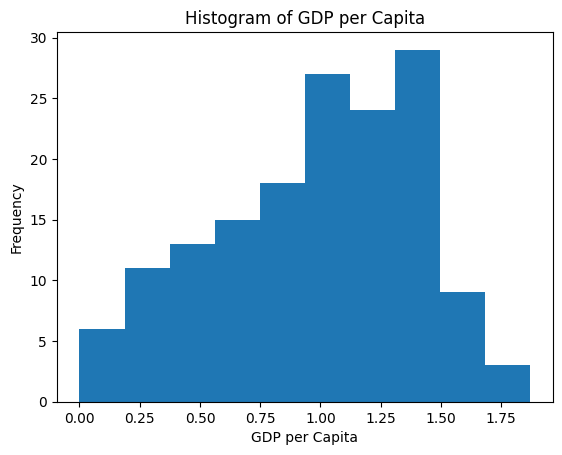

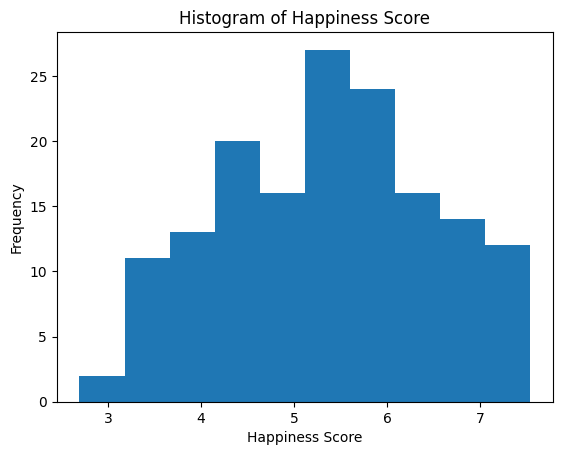

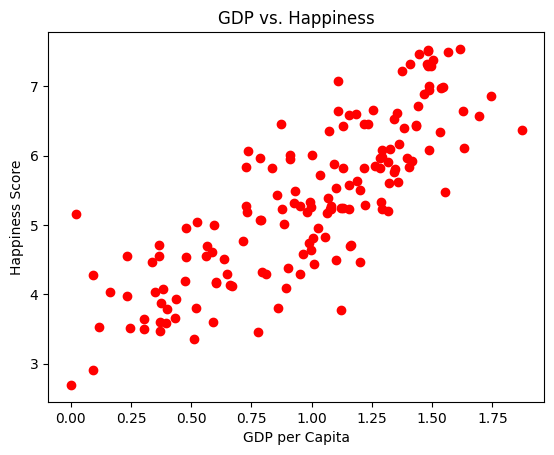

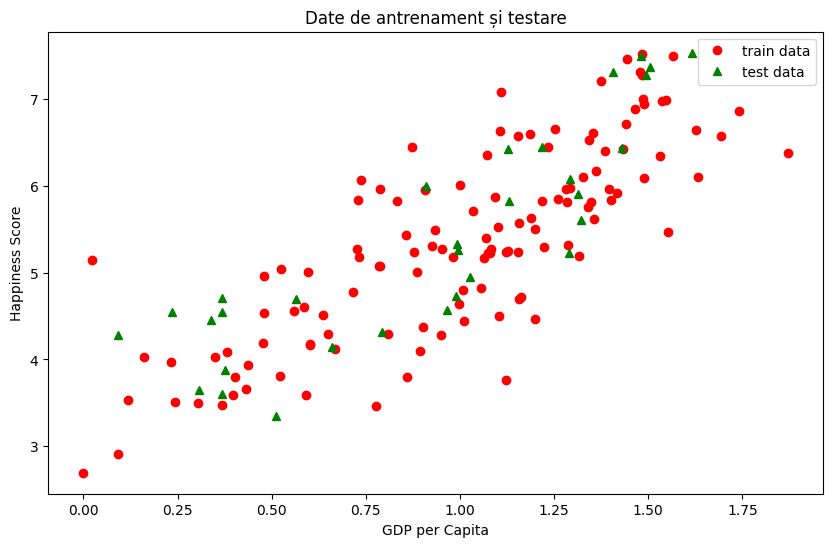


--- Antrenare cu SGD propriu ---
Modelul învățat (SGD): f(x) = 0.000000 + 0.799785 * x

--- Antrenare cu BGD propriu ---
Modelul învățat (BGD): f(x) = 0.000524 + 0.800095 * x


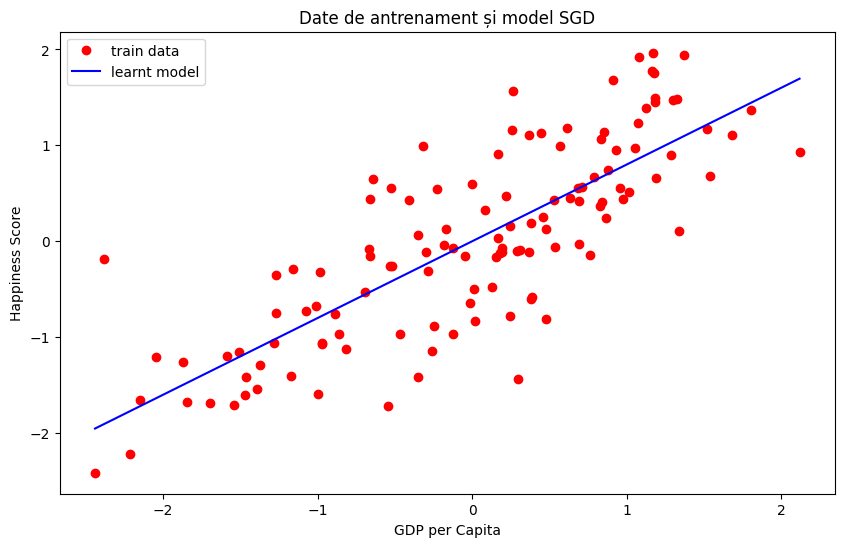

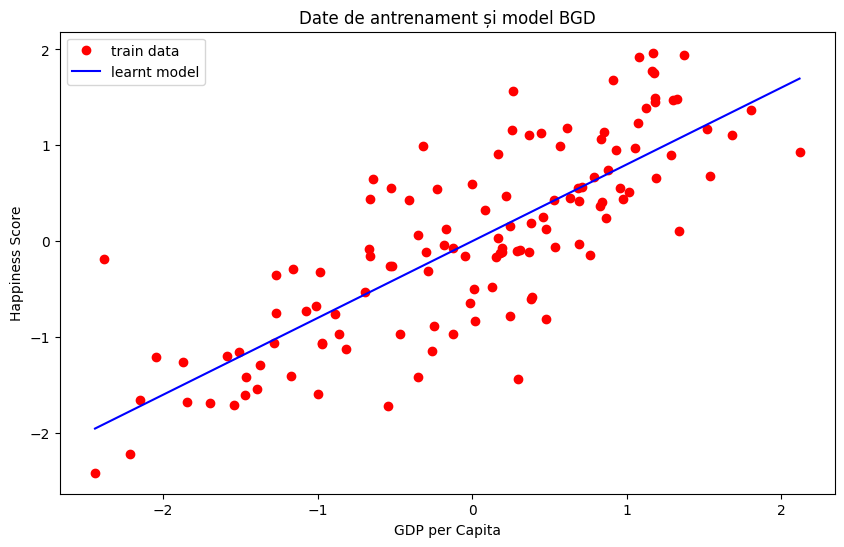

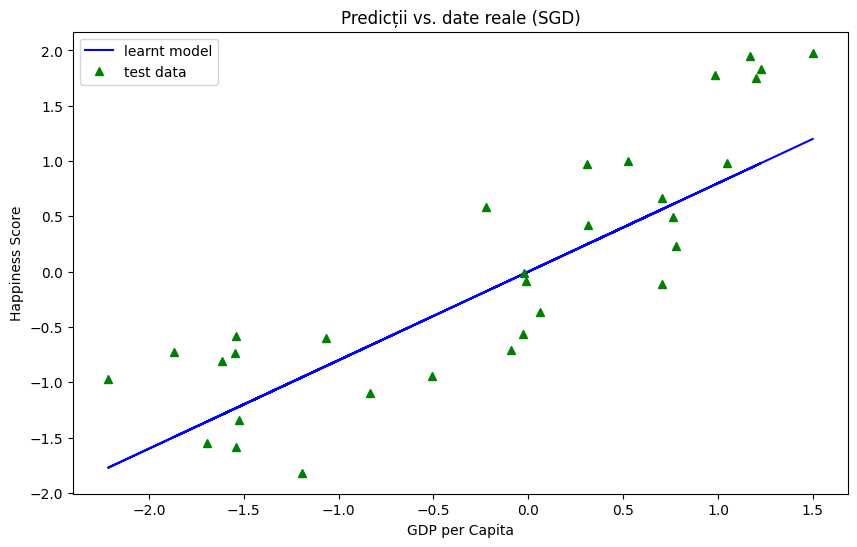

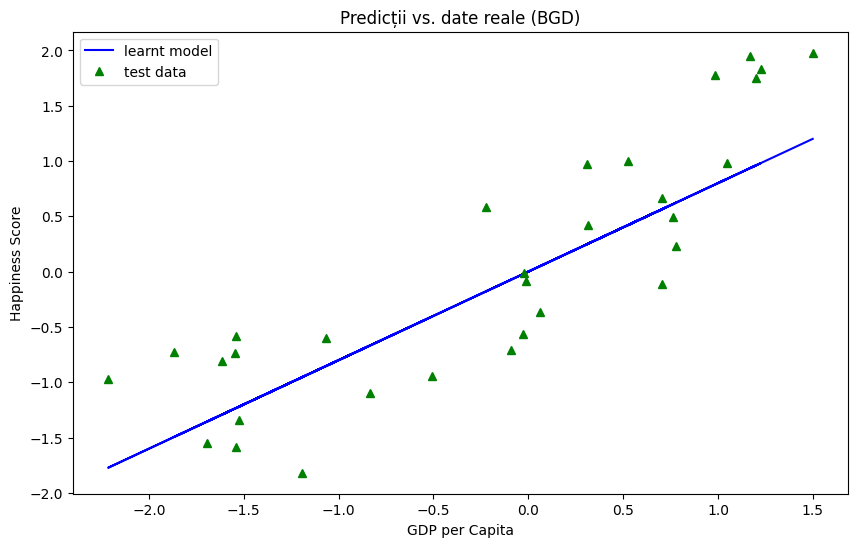


Eroare de predicție (SGD): 0.340348
Eroare de predicție (BGD): 0.340142

--- Antrenare cu SGDRegressor (tool sklearn) ---
Modelul învățat (SGDRegressor): f(x) = -0.004794 + 0.814615 * x


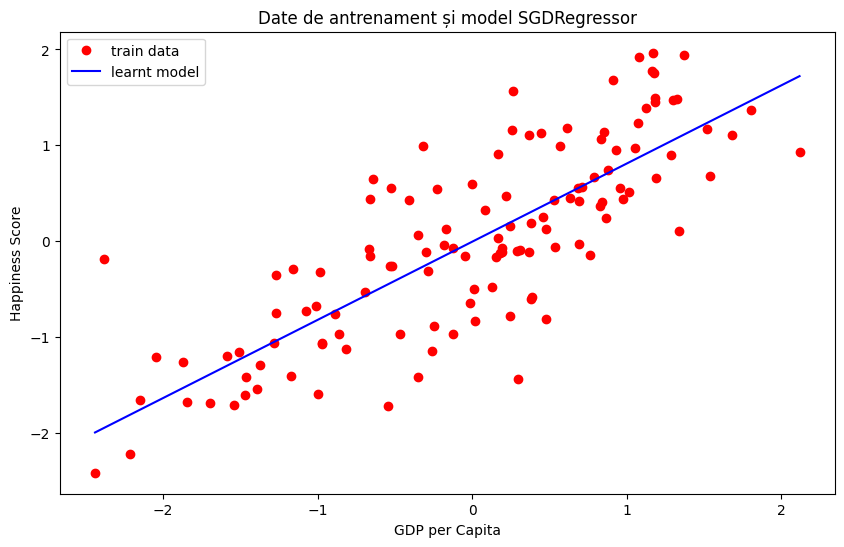

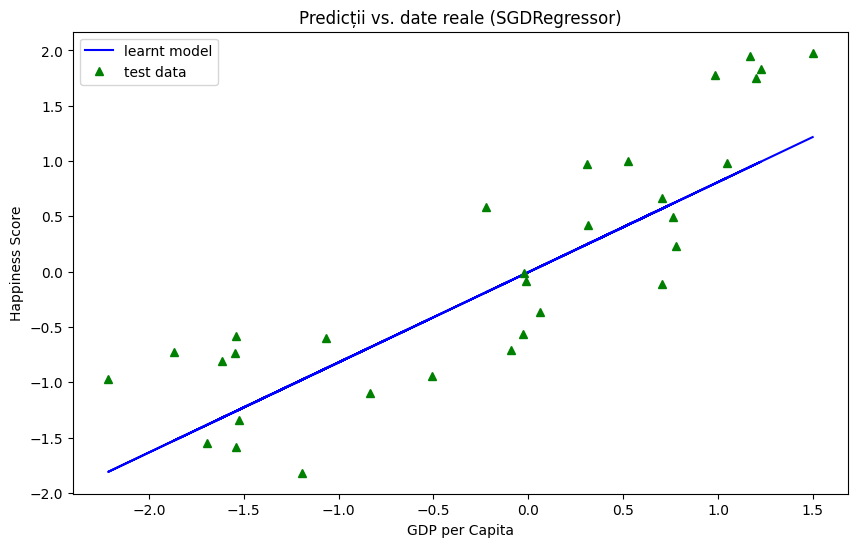

Eroare de predicție (SGDRegressor): 0.340467


In [92]:
 # 1. Regresia univariată: Happiness = f(GDP)
univariateRegression()


=== REGRESIA BIVARIATĂ: Happiness = f(GDP, Freedom) ===



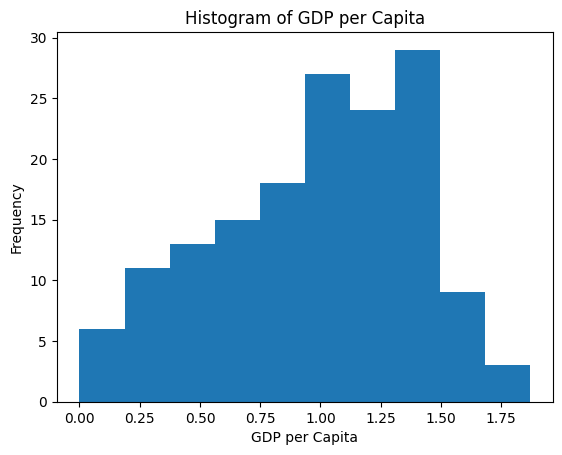

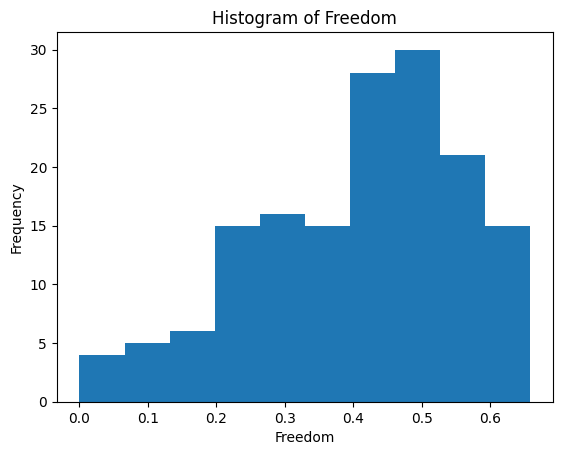

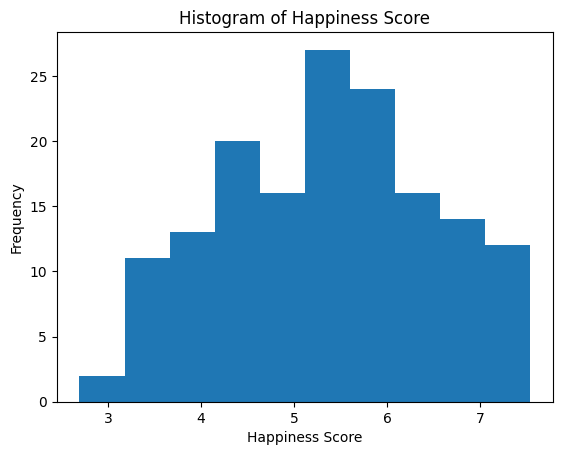

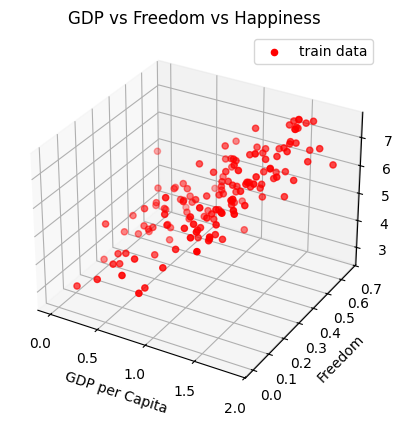

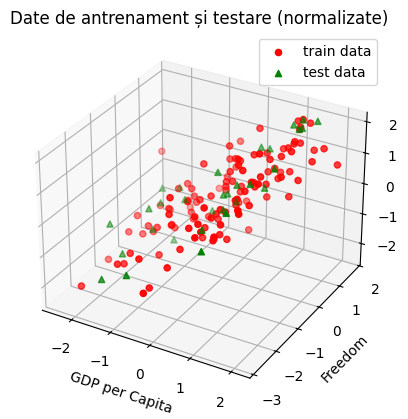


--- Antrenare cu SGD propriu ---
Modelul învățat (SGD): f(x) = 0.000000 + 0.697649 * x1 + 0.304886 * x2

--- Antrenare cu BGD propriu ---
Modelul învățat (BGD): f(x) = 0.000480 + 0.698514 * x1 + 0.304722 * x2


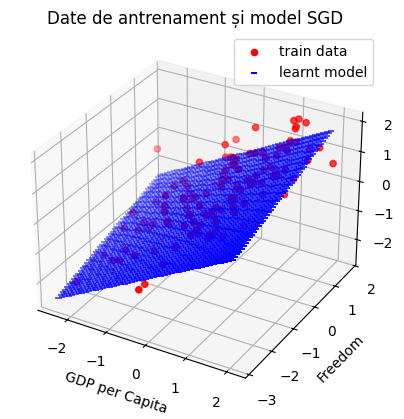

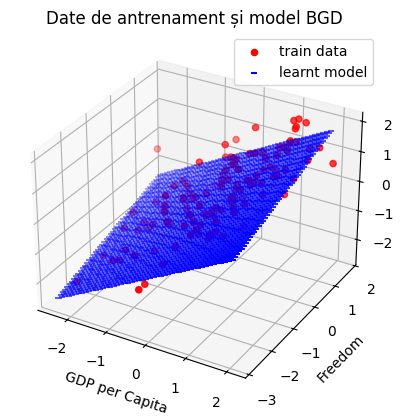

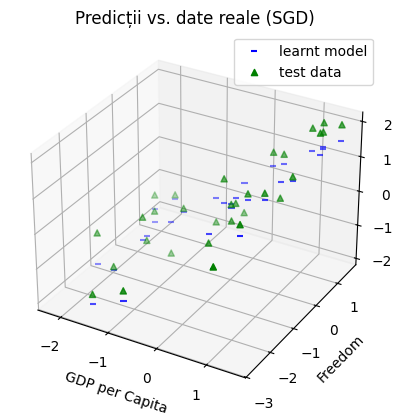

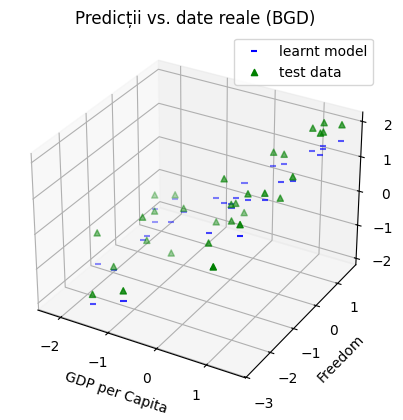


Eroare de predicție (SGD): 0.228267
Eroare de predicție (BGD): 0.228139

--- Antrenare cu SGDRegressor (tool sklearn) ---
Modelul învățat (SGDRegressor): f(x) = -0.005971 + 0.708778 * x1 + 0.278820 * x2


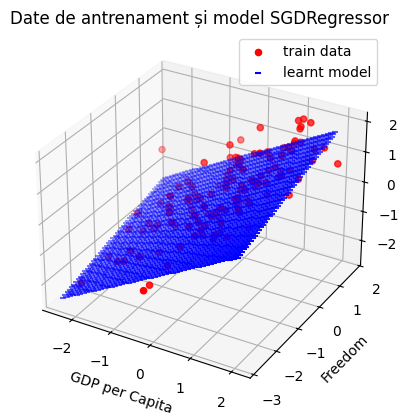

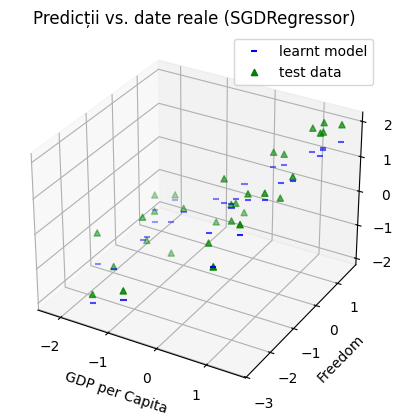

Eroare de predicție (SGDRegressor): 0.232106


In [93]:
# 2. Regresia bivariată: Happiness = f(GDP, Freedom)
bivariateRegression()